<a id='section_id3'></a>
# Haushalt mit Photovoltaikanlage und Speichersystem - Validierung der Simulation


## Formelzeichen

\begin{eqnarray}
P_{pk} &=& Peakleistung\ der\ Photovoltaikanlage\ in\ W \\
PR &=& Performance\ Ratio\ PV\ ohne\ Einheit\\
G_{stc} &=& durchschnittliche\ Strahlung\ auf\ Meereshöhe\ in\ \frac{W}{m^2} \\
v &=& Kollektorenausrichtung\ Abweichung\ von\ Süden\ in\ Grad\\
inclination &=& Neigung\ Kollektor\ zur\ Horizontalen\ in\ Grad\\
G_h &=& Bestrahlungsleistung\ in\ der\ Ebene\ in\ \frac{W}{m^2}\\
z &=& Sonnenzenit\ in\ Grad\\
\\
P_{pv} &=& Photovoltaikleistung\ in\ W\\
P_{verbraucher} &=& Verbraucherleistung\ in\ W\\
P_{dif} &=& P_{pv}-P_{verbraucher} \ resultierende\ Differenzleistung\ bei\ Eigennutzung\ ohne\ Speicher\ in\ W\ -\ Überschuss\ positiv,\ Defizit\ negativ\\
P_{ueber} &=& Überschussleistung\ in\ W\\
P_{def} &=& Defizitleistung\ in\ W\ (Betrag)\\
\end{eqnarray}


## Initialisierung

In [1]:
from parameter_base_case import *

lastprofile = read.HTW_profiles()
G_h, z = read.solar_data()

# -------------------------------------------------------------------------------------------------------------

## Validierung repräsentatives Profil 31

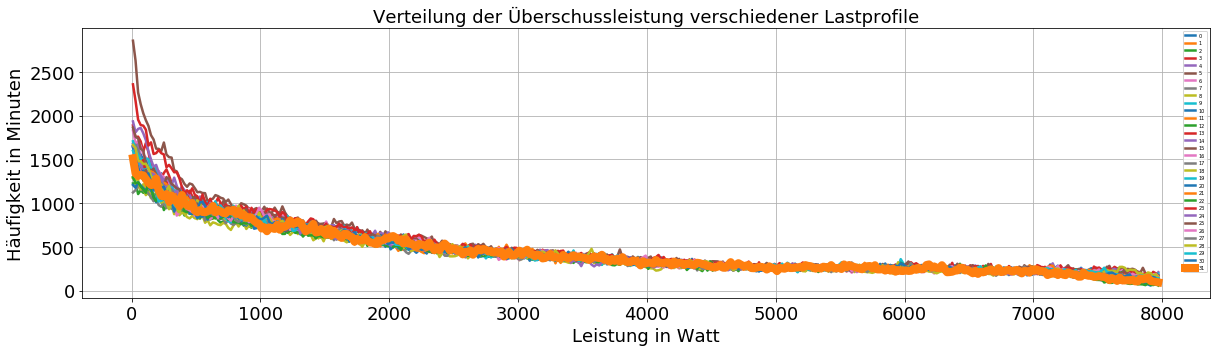

In [2]:
lastprofilnummern = np.arange(0,32)
first=1
for value in lastprofilnummern:
    ##Lastprofile berechnen
    P_verbraucher = lastprofile[:,value]
    P_pv = pv.calculate_power(G_h, z, P_peak, PR, G_stc, v, inclination)
    P_dif = P_pv-P_verbraucher
    #P_def = ufcn.negval_cutoff(-P_dif)
    #P_ueber = ufcn.negval_cutoff(P_dif)
    upperlim=8000
    n,bins=np.histogram(P_dif, bins=np.arange(10,upperlim,20))
    if first>0:
        ax=vis.plot(bins[0:np.size(bins)-1],n,'Leistung in Watt','Häufigkeit in Minuten',\
                    'Verteilung der Überschussleistung verschiedener Lastprofile')
        first=0
        legend=[value]
    else:
        vis.addtoplot(ax,bins[0:np.size(bins)-1],n,'','upper right')
        legend.append(value)

ax.lines[31].set_linewidth(8)    
ax.legend(legend,fontsize=5)

## Vergleich mit verschiedenen Rechenmodellen für den Autarkiegrad

\
Parameter werden für Vegleich mit anderen Rechnern angepasst

In [3]:
#Photovoltaik Anlage
P_peak=5000
PR=0.8
G_stc=1000
v=0          #Kollektorenausrichtung Abweichung von Südausrichtung in Grad
inclination=35 #Kollektorwinkel zur horizontalen in Grad

#Verbraucher
LastprofilNr = 31;

P_batterie_charge_max = 3000
P_batterie_discharge_max = 3000
eff_batterie = 0.95

##Lastprofile berechnen
P_verbraucher = lastprofile[:,LastprofilNr]

#auf 5000kWh normieren
E_verbraucher = jahresenergie_kWh(P_verbraucher)
x=5000/E_verbraucher
P_verbraucher = P_verbraucher*x
E_verbraucher = jahresenergie_kWh(P_verbraucher)

P_pv = pv.calculate_power(G_h, z, P_peak, PR, G_stc, v, inclination)
P_dif = P_pv-P_verbraucher
P_def = negval_cutoff(-P_dif)
P_ueber = negval_cutoff(P_dif)
E_def = jahresenergie_kWh(P_def)
E_ueber = jahresenergie_kWh(P_ueber)


####################################################################################################################
E_batterie_max_array = np.linspace(0,14,8)


first=0
E_bat_used=np.zeros(np.size(E_batterie_max_array))
print('<Simulationsfortschritt>')
for i,value in enumerate(E_batterie_max_array):
    E_bat, P_batterie_charge, P_batterie_discharge = speicher.batterie_lastprofile(P_dif, P_batterie_charge_max, \
            P_batterie_discharge_max, eff_batterie, value)
    E_bat_used[i] = jahresenergie_kWh(P_batterie_discharge)
    print('.',end="")
    


<Simulationsfortschritt>
........

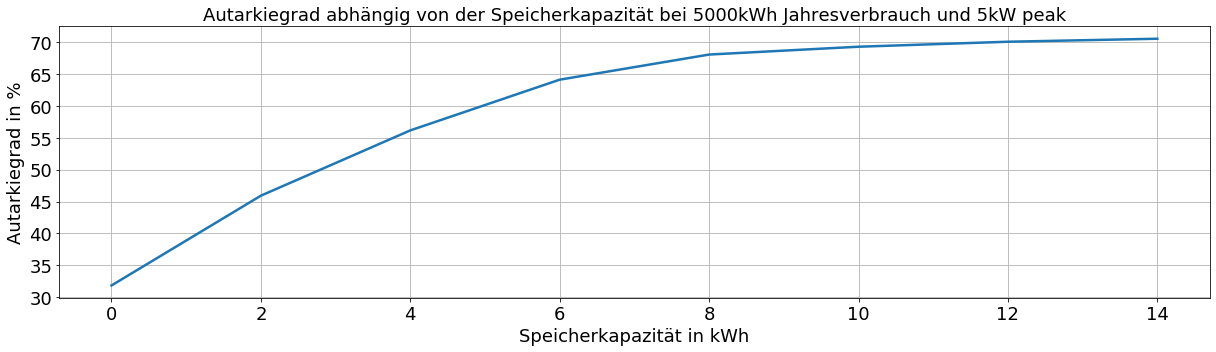

In [4]:
autarkiegrad = (E_verbraucher-jahresenergie_kWh(P_def)+E_bat_used)/E_verbraucher
ax=vis.plot(E_batterie_max_array, autarkiegrad*100,'Speicherkapazität in kWh',\
        'Autarkiegrad in %','Autarkiegrad abhängig von der Speicherkapazität bei 5000kWh Jahresverbrauch und 5kW peak')

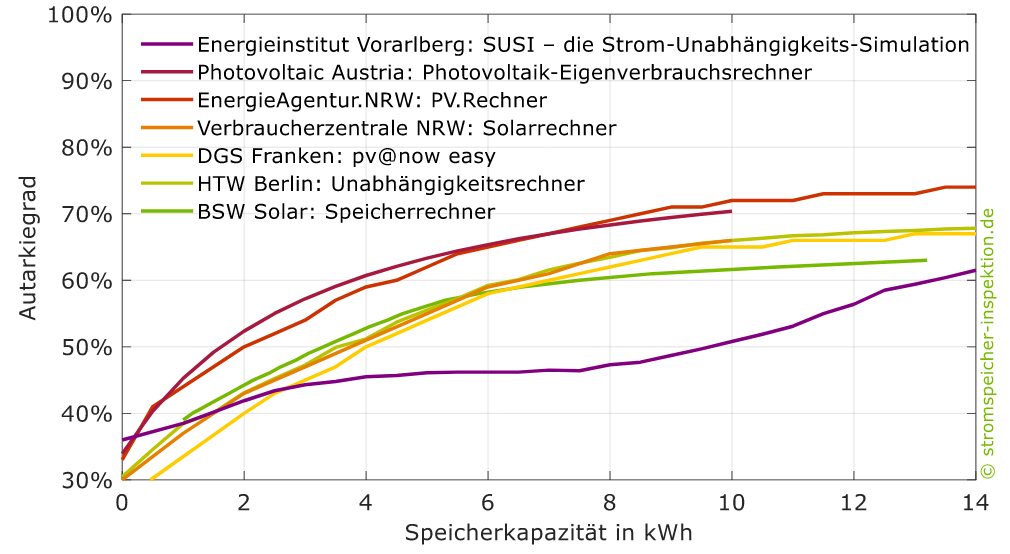